## 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

## 2. StateGraph
- 상태(state)를 기반으로 작동하는 그래프 구조
- 실습: 서울시 행정구(아파트/상권) 추천 시스템
    - 사용자의 선호도에 따라 행정구를 추천하고, 해당 행정구의 부동산/상권 정보를 제공

`(1) 상태(State)`
- 상태는 그래프가 처리하는 데이터의 구조를 정의
- 기존 상태를 override (덮어쓰기)

In [3]:
from typing import TypedDict

# 상태 Schema 정의 - 사용자의 선호도, 추천된 행정구, 그리고 행정구 정보를 저장
class DistrictState(TypedDict):
    user_preference: str  # 사용자의 선호도(예: 교통, 학군 등)
    recommended_district: str  # 추천된 행정구(예: 양천구)
    district_info: str  # 행정구 정보(예: 평균가, 주요 아파트, 설명 등)


`(2) 노드(Node)`
- 노드는 그래프에서 실제 작업을 수행하는 함수

In [4]:
from typing import TypedDict

# 상태 Schema 정의 - 사용자의 선호도, 추천된 행정구, 그리고 행정구 정보를 저장
class DistrictState(TypedDict):
    user_preference: str  # 사용자의 선호도(예: 학군, 교통, 자연환경 등)
    recommended_district: str  # 추천된 행정구(예: 양천구)
    district_info: str  # 행정구 정보(예: 평균가, 주요 아파트, 설명 등)

import random

def get_user_preference_district(state: DistrictState) -> DistrictState:
    print("---랜덤 사용자 선호도 생성---")
    preferences = ["학군", "교통", "자연환경", "생활 인프라"]
    preference = random.choice(preferences)
    print(f"생성된 선호도: {preference}")
    return {"user_preference": preference}

def recommend_district(state: DistrictState) -> DistrictState:
    print("---행정구 추천---")
    preference = state['user_preference']
    if preference == "학군":
        district = "양천구"
    elif preference == "교통":
        district = "마포구"
    elif preference == "자연환경":
        district = "강동구"
    else:
        district = "강남구"
    print(f"추천 행정구: {district}")
    return {"recommended_district": district}

def provide_district_info(state: DistrictState) -> DistrictState:
    print("---행정구 정보 제공---")
    district = state['recommended_district']
    if district == "양천구":
        info = "20평대 평균가: 10.5억, 주요 아파트: 신정동 롯데캐슬, 목동 현대, 목동 신시가지 1~14단지. 설명: 학군이 우수하고, 대규모 아파트 단지와 쾌적한 주거환경으로 가족 단위 거주자들에게 인기."
    elif district == "마포구":
        info = "20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역."
    elif district == "강동구":
        info = "20평대 평균가: 10.2억, 주요 아파트: 천호동 한라, 고덕 롯데, 성내 현대. 설명: 도심에서 떨어져 있지만 자연환경과 주거환경이 좋은 지역."
    else:
        info = "20평대 평균가: 20.5억, 주요 아파트: 현대캐피탈, 타워팰리스, 삼성래미안. 설명: 비즈니스 중심지, 다양한 문화시설과 편리한 교통망이 특징."
    print(f"행정구 정보: {info}")
    return {"district_info": info}

# 그래프 빌드 및 실행 부분도 DistrictState, 함수명, 출력문 등 모두 위에 맞게 변경



`(3) 그래프(Graph) 구성`
- 정의한 구성 요소들을 사용하여 전체 그래프를 빌드

In [5]:
from langgraph.graph import StateGraph, START, END

# 그래프 빌더 생성
builder = StateGraph(DistrictState)

# 노드 추가
builder.add_node("get_preference", get_user_preference_district)
builder.add_node("recommend", recommend_district)
builder.add_node("provide_info", provide_district_info)

# 엣지 추가
builder.add_edge(START, "get_preference")
builder.add_edge("get_preference", "recommend")
builder.add_edge("recommend", "provide_info")
builder.add_edge("provide_info", END)

# 그래프 컴파일
graph = builder.compile()

def print_result(result: DistrictState):
    print("\n=== 결과 ===")
    print("선호도:", result['user_preference'])
    print("추천 행정구:", result['recommended_district'])
    print("행정구 정보:", result['district_info'])
    print("============\n")

# 초기 입력
inputs = {"user_preference": ""}

# 여러 번 실행하여 테스트
for _ in range(2):
    result = graph.invoke(inputs)
    print_result(result)
    print("*"*100)
    print()


---랜덤 사용자 선호도 생성---
생성된 선호도: 교통
---행정구 추천---
추천 행정구: 마포구
---행정구 정보 제공---
행정구 정보: 20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역.

=== 결과 ===
선호도: 교통
추천 행정구: 마포구
행정구 정보: 20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역.

****************************************************************************************************

---랜덤 사용자 선호도 생성---
생성된 선호도: 교통
---행정구 추천---
추천 행정구: 마포구
---행정구 정보 제공---
행정구 정보: 20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역.

=== 결과 ===
선호도: 교통
추천 행정구: 마포구
행정구 정보: 20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역.

****************************************************************************************************



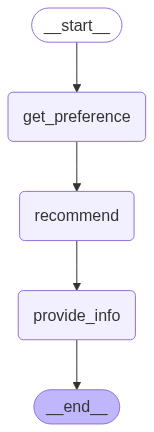

In [6]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# 그래프 실행

def print_result(result: DistrictState):
    print("\n=== 결과 ===")
    print("선호도:", result['user_preference'])
    print("추천 행정구:", result['recommended_district'])
    print("행정구 정보:", result['district_info'])
    print("============\n")

# 초기 입력
inputs = {"user_preference": ""}

# 여러 번 실행하여 테스트
for _ in range(2):
    result = graph.invoke(inputs)
    print_result(result)
    print("*"*100)
    print()

---랜덤 사용자 선호도 생성---
생성된 선호도: 교통
---행정구 추천---
추천 행정구: 마포구
---행정구 정보 제공---
행정구 정보: 20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역.

=== 결과 ===
선호도: 교통
추천 행정구: 마포구
행정구 정보: 20평대 평균가: 14.2억, 주요 아파트: 마포래미안푸르지오, 마포그랑자이, 상암 DMC. 설명: 교통, 생활 인프라, 젊은 층 선호도가 높은 지역.

****************************************************************************************************

---랜덤 사용자 선호도 생성---
생성된 선호도: 생활 인프라
---행정구 추천---
추천 행정구: 강남구
---행정구 정보 제공---
행정구 정보: 20평대 평균가: 20.5억, 주요 아파트: 현대캐피탈, 타워팰리스, 삼성래미안. 설명: 비즈니스 중심지, 다양한 문화시설과 편리한 교통망이 특징.

=== 결과 ===
선호도: 생활 인프라
추천 행정구: 강남구
행정구 정보: 20평대 평균가: 20.5억, 주요 아파트: 현대캐피탈, 타워팰리스, 삼성래미안. 설명: 비즈니스 중심지, 다양한 문화시설과 편리한 교통망이 특징.

****************************************************************************************************



## 3. 조건부 엣지(Edge)
- 엣지는 노드 간의 연결을 정의
- 조건부 엣지: 사용자 입력이 메뉴 관련인지 여부에 따라 다른 경로로 진행

`(1) State 정의`
- 사용자 입력이 메뉴 추천이면 벡터저장소에서 검색하여 RAG Chain을 실행하고,
- 그렇지 않은 경우에는 LLM이 답변을 생성

In [8]:
from typing import List

# state 스키마 
class DistrictRagState(TypedDict):
    user_query: str
    is_district_related: bool
    search_results: List[str]
    final_answer: str


`(2) 벡터저장소 검색 도구`
- 지역 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [9]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="commercial",
    persist_directory="./chroma_db",
)



`(3) 노드(Node)`

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

def get_user_query(state: DistrictRagState) -> DistrictRagState:
    user_query = input("무엇을 도와드릴까요? ")
    return {"user_query": user_query}

def analyze_input(state: DistrictRagState) -> DistrictRagState:
    analyze_template = """
    사용자의 입력을 분석하여 서울시 행정구(아파트/상권) 추천이나 정보에 관한 질문인지 판단하세요.

    사용자 입력: {user_query}

    행정구 추천 또는 정보에 관한 질문이면 "True", 아니면 "False"로 답변하세요.

    답변:
    """
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_district_related = result.strip().lower() == "true"
    
    return {"is_district_related": is_district_related}

def search_district_info(state: DistrictRagState) -> DistrictRagState:
    # 벡터저장소에서 최대 2개의 문서를 검색 
    results = vector_db.similarity_search(state['user_query'], k=2)
    search_results = [doc.page_content for doc in results]
    return {"search_results": search_results}

def generate_district_response(state: DistrictRagState) -> DistrictRagState:
    response_template = """
    사용자 입력: {user_query}
    행정구 관련 검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 행정구 관련 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke({"user_query": state['user_query'], "search_results": state['search_results']})
    print(f"\n행정구 어시스턴트: {final_answer}")
    
    return {"final_answer": final_answer}

def generate_general_response(state: DistrictRagState) -> DistrictRagState:
    response_template = """
    사용자 입력: {user_query}

    위 입력은 행정구(아파트/상권)와 관련이 없습니다. 
    일반적인 대화 맥락에서 적절한 답변을 생성하세요.

    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke({"user_query": state['user_query']})
    print(f"\n일반 어시스턴트: {final_answer}")
    
    return {"final_answer": final_answer}


`(4) 엣지(Edge)`

In [11]:
from typing import Literal

def decide_next_step(state: DistrictRagState) -> Literal["search_district_info", "generate_general_response"]:
    if state['is_district_related']:
        return "search_district_info"  
    else:
        return "generate_general_response"

`(5) 그래프(Graph) 구성`

In [12]:
from langgraph.graph import StateGraph, START, END

# 그래프 구성
builder = StateGraph(DistrictRagState)

# 노드 추가
builder.add_node("get_user_query", get_user_query)
builder.add_node("analyze_input", analyze_input)
builder.add_node("search_district_info", search_district_info)
builder.add_node("generate_district_response", generate_district_response)
builder.add_node("generate_general_response", generate_general_response)

# 엣지 추가
builder.add_edge(START, "get_user_query")
builder.add_edge("get_user_query", "analyze_input")

# 조건부 엣지 추가
builder.add_conditional_edges(
    "analyze_input",
    decide_next_step,
    {
        "search_district_info": "search_district_info",
        "generate_general_response": "generate_general_response"
    }
)

builder.add_edge("search_district_info", "generate_district_response")
builder.add_edge("generate_district_response", END)
builder.add_edge("generate_general_response", END)

# 그래프 컴파일
graph = builder.compile()

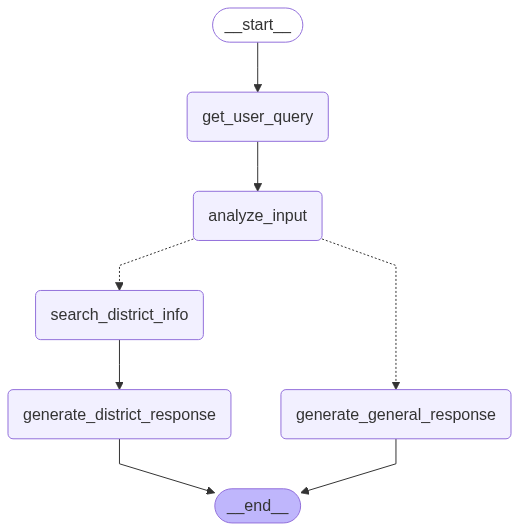

In [13]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(6) Graph 실행`

In [17]:
while True:
    initial_state = {'user_query':''}
    graph.invoke(initial_state) 
    continue_chat = input("다른 질문이 있으신가요? (y/n): ").lower()
    if continue_chat != 'y':
        print("대화를 종료합니다. 감사합니다!")
        break


행정구 어시스턴트: 서울에서 가성비 좋은 상권을 찾고 계신다면, 몇 가지 추천 지역이 있습니다. 

1. **홍대**: 홍익대학교 주변은 젊은 층이 많이 찾는 지역으로, 다양한 카페와 식당이 경쟁력 있는 가격으로 제공됩니다. 특히, 저렴한 가격에 맛있는 음식과 음료를 즐길 수 있는 곳들이 많습니다.

2. **신림**: 대학가가 있는 이 지역은 학생들을 위한 가성비 좋은 음식점과 술집들이 많습니다. 특히, 저렴한 가격에 푸짐한 양의 메뉴를 제공하는 곳들이 많아 인기가 높습니다.

3. **관악구**: 서울대 인근에는 다양한 가성비 좋은 식당과 카페들이 있습니다. 이 지역은 학생들이 많이 찾는 만큼 가격도 적당한 편입니다.

4. **구로디지털단지**: IT 기업들이 밀집해 있는 이곳은 다양한 음식점과 카페들이 있으며, 가격대도 합리적입니다. 특히 점심시간에 가성비 좋은 도시락이나 뷔페식당을 이용할 수 있습니다.

5. **을지로**: 최근 핫플레이스로 떠오르고 있는 을지로는 다양한 소규모 식당과 바들이 있어 저렴한 가격에 다양한 음식을 즐길 수 있는 곳입니다.

이 외에도 서울 곳곳에는 가성비 좋은 상권이 많으니, 다양한 지역을 탐방해 보시는 것도 좋습니다!
대화를 종료합니다. 감사합니다!
